### Converting Tensorflow Model to TensorFlow Lite Model

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

tfds.disable_progress_bar()

In [2]:
class_names = ['Fire', 'NoFire']

In [3]:
# Convert the model
saved_model_dir = 'C:\\Users\\hp\\OneDrive\\Code\\AI Projects\\Fire_Detection\\final_model\\1'
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) # path to the SavedModel directory
tflite_model = converter.convert()

In [4]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [5]:
def normalize(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (128, 128))
  image = image / 255.0
  return image, label

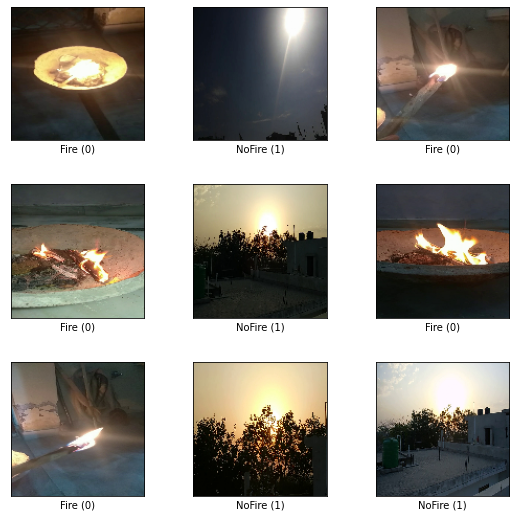

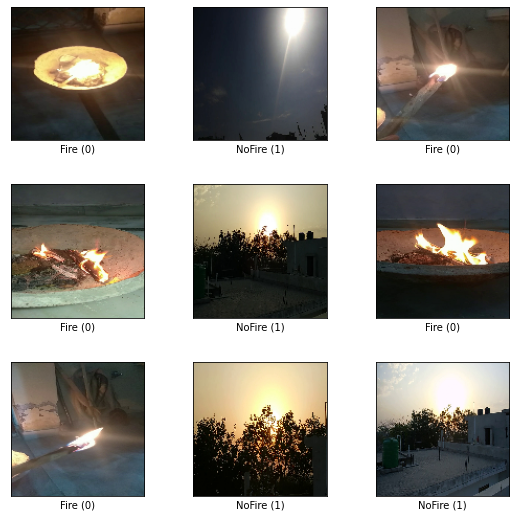

In [6]:
builder = tfds.ImageFolder('D:\\Data')
#print(builder.info)  # num examples, labels... are automatically calculated
#Split, choose which folder to load. if not specified, it loads all folders
ds = builder.as_dataset(split='test', shuffle_files=True,  as_supervised = True) #set to test set for test set
ds = ds.map(normalize)
tfds.show_examples(ds, builder.info)

In [8]:
for img, label in ds.take(50):
    print(label.numpy())

1
1
0
0
0
0
0
1
0
0
1
1
1
0
1
1
0
0
1
0
1
0
1
0
0
0
0
1
0
0
1
0
0
0
0
1
0
0
0
1
1
0
0
0
1
1
1
0
1
1


In [10]:
# Gather results for the randomly sampled test images
predictions = []
test_labels = []
test_images = []

for img, label in ds.take(870):
  img = np.expand_dims(img, axis=0).astype(np.float32)
  interpreter.set_tensor(input_index, img)
  interpreter.invoke()
  predictions.append(interpreter.get_tensor(output_index))
  fire_prob = interpreter.get_tensor(output_index)[0][0] * 100
  test_labels.append(label.numpy())
  test_images.append(img)

In [11]:
#@title Utility functions for plotting
# Utilities for plotting

def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  img = np.squeeze(img)

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'green'
  else:
    color = 'red'
    
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks(list(range(2)), class_names, rotation='vertical')
  plt.yticks([])
  thisplot = plt.bar(range(2), predictions_array[0], color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array[0])

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('green')

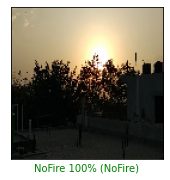

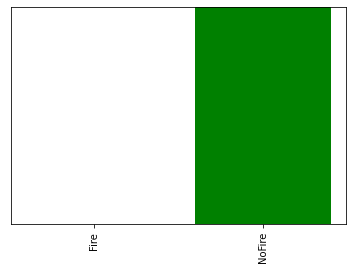

In [12]:
#@title Visualize the outputs { run: "auto" }
index = 0 #@param {type:"slider", min:1, max:10, step:1}
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_images)
plt.show()
plot_value_array(index, predictions, test_labels)
plt.show()

In [93]:
# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [25]:
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]
  
  # Run predictions on every image in the "test" dataset.
  plt.figure(figsize=(15,15))
  prediction_digits = []
  test_labels = []
  test_images = []
  for test_image, test_label in ds.take(871):
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    prediction_digits.append(interpreter.get_tensor(output_index))
    test_labels.append(test_label.numpy())
    test_images.append(test_image)

  # Compare prediction results with ground truth labels to calculate accuracy.
  accurate_count = 0
  fire_correct = 0
  fire_incorrect = 0
  nofire_correct = 0
  nofire_incorrect= 0
  inaccurate_count = 0
  print(len(test_labels))
  for index in range(len(prediction_digits)):
    prediction = np.argmax(prediction_digits[index])
    if prediction == test_labels[index]:
      accurate_count += 1
      if prediction == 0:
        fire_correct+=1
      else:
        nofire_correct+=1
    else:
      inaccurate_count+=1
      plt.subplot(10,5,inaccurate_count)
      plt.grid(False)
      plt.xticks([])
      plt.yticks([])
      if prediction == 0:
        fire_incorrect+=1
      else:
        nofire_incorrect+=1
      img = np.squeeze(test_images[index])
      color = "green" if prediction == test_labels[index] else "red"
      plt.title(class_names[prediction].title()+"-"+ str(round(100*np.max(prediction_digits[index]),2)), color=color)
      plt.axis('off')
      plt.suptitle("Model predictions (Green: correct, red: incorrect)")
      plt.imshow(img, cmap=plt.cm.binary)
      plt.xlabel("{} {:2.0f}% ({})".format(class_names[prediction],
                                100*np.max(prediction_digits[index]),
                                class_names[test_labels[index]])
                                 )
  accuracy = accurate_count * 1.0 / len(prediction_digits)
  print("Accurate:",accurate_count,"and inaccurate",inaccurate_count)
  print("Correct   Fire:",str(fire_correct),"No Fire:",str(nofire_correct))
  print("InCorrect Fire:",str(fire_incorrect),"No Fire:",str(nofire_incorrect))

  return accuracy

871
Accurate: 830 and inaccurate 41
Correct   Fire: 561 No Fire: 269
InCorrect Fire: 9 No Fire: 32
Overall Accuracy 0.9529276693455798


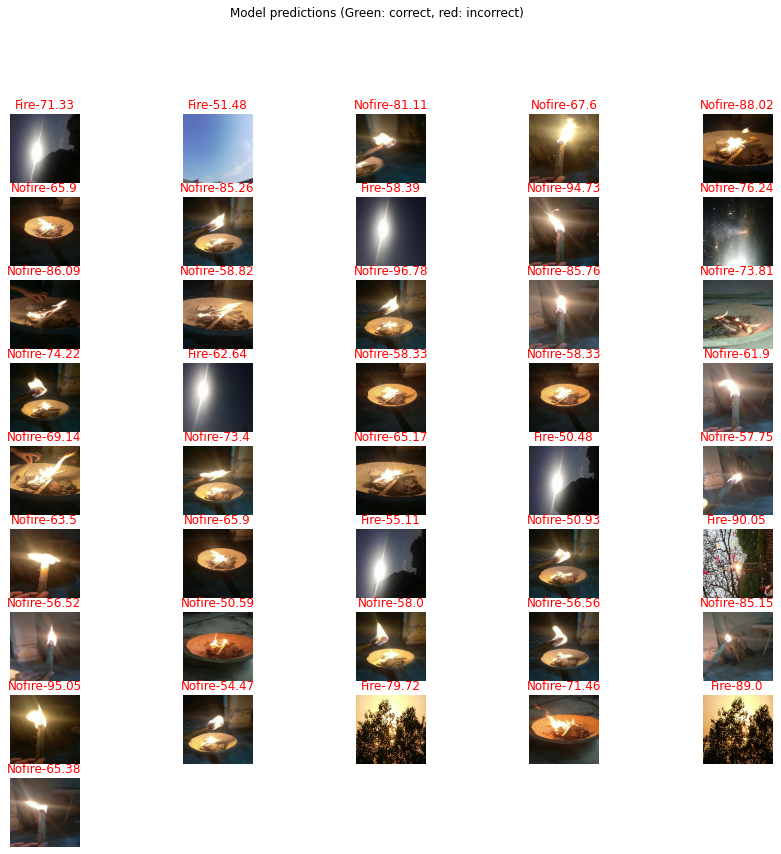

In [26]:
print("Overall Accuracy",evaluate_model(interpreter))
#Evaluate with the post dynamic optimization model